<a href="https://colab.research.google.com/github/TrybinD/educational-projects/blob/main/ML%20projects/House_pricing/version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniiltrubin","key":"a0e37acddb328217e1f38b5525aa2e78"}'}

In [ ]:
! pip install kaggle -q
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 28.8MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.1MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 28.5MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 63.0MB/s]


Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from scipy import stats
from scipy.stats import norm, skew

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
print("Размер train датасета до удаления ID : {} ".format(train.shape))
print("Размер test датасета до удаления ID  : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("Размер train датасета после удаления ID  : {} ".format(train.shape)) 
print("Размер test датасета после удаления ID  : {} ".format(test.shape))

Размер train датасета до удаления ID : (1460, 81) 
Размер test датасета до удаления ID  : (1459, 80) 
Размер train датасета после удаления ID  : (1460, 80) 
Размер test датасета после удаления ID  : (1459, 79) 


Подготовка данных

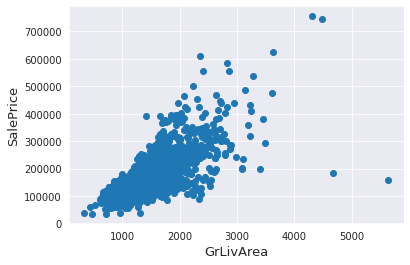

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Видим 2 выброса, которые честно, говоря не очень.... - удаляем

In [ ]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 700000)].index)

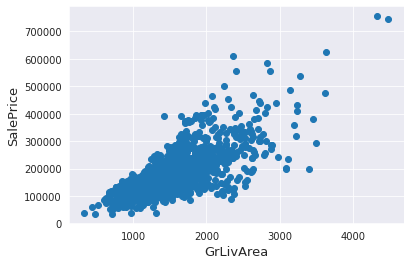

In [ ]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13);

Поизучаем нашу целевую переменную

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Нормальное распределение. Мат. Ожидание = 180932.92, Дисперсия = 79467.79


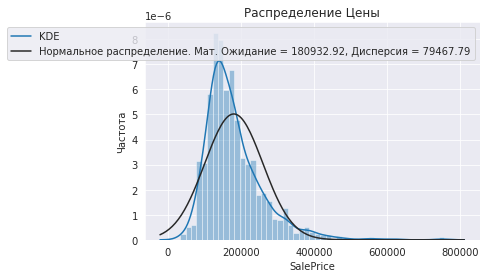

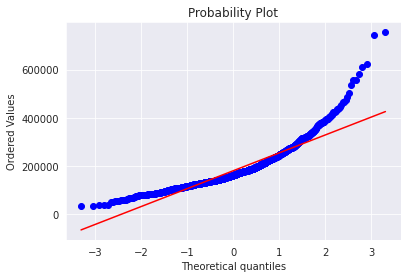

In [ ]:
sns.distplot(train.SalePrice, fit=norm);
a, sigma = norm.fit(train.SalePrice)
print("Нормальное распределение. Мат. Ожидание = {:.2f}, Дисперсия = {:.2f}".format(a, sigma))

plt.legend(["KDE","Нормальное распределение. Мат. Ожидание = {:.2f}, Дисперсия = {:.2f}".format(a, sigma)], loc = "best")
plt.ylabel("Частота")
plt.title("Распределение Цены")


fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



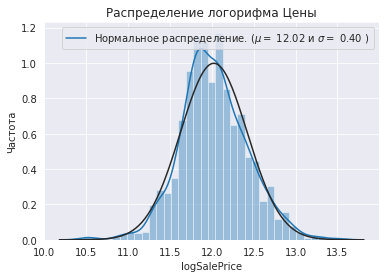

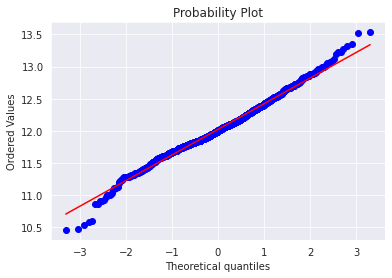

In [ ]:
train["logSalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['logSalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['logSalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Нормальное распределение. ($\mu=$ {:.2f} и $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Частота')
plt.title('Распределение логорифма Цены')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['logSalePrice'], plot=plt)
plt.show()

Создание фичей

In [ ]:
# Объединяем трейн и тест датасеты (не совсем честно, но ладно)


ntrain = train.shape[0]# чтобы потом удобно отделить
ntest = test.shape[0]

y_train = train.logSalePrice.values #помним что целевая переменная у нас логорифмирована!

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice', "logSalePrice"], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


Для начала посмотрим пропуски (но в последствии хорошо бы это делать импутером)

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing values": all_data_na})
missing_data

,Missing values
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


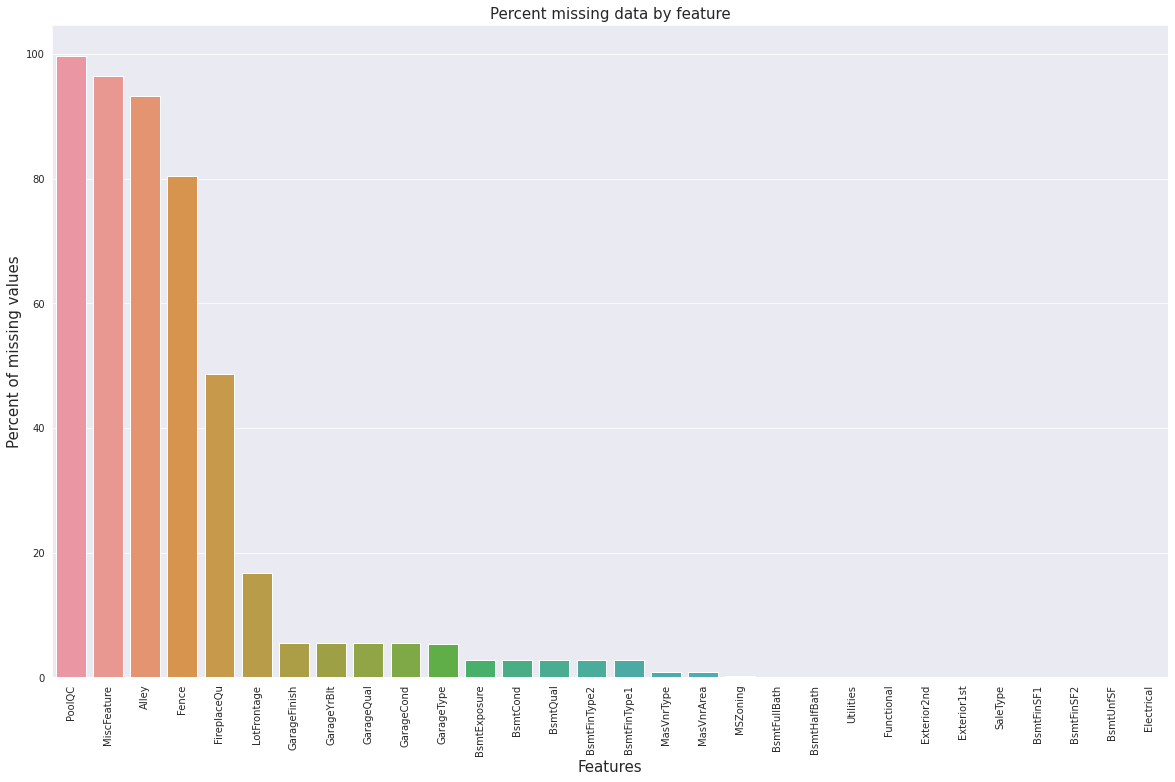

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

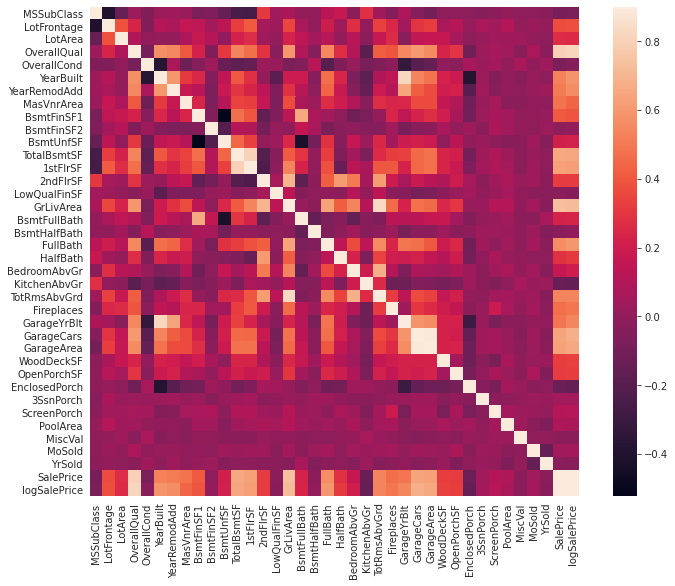

In [ ]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
corrmat["logSalePrice"].sort_values(ascending=False)[:10]

logSalePrice    1.000000
SalePrice       0.948396
OverallQual     0.821405
GrLivArea       0.725211
GarageCars      0.681033
GarageArea      0.656129
TotalBsmtSF     0.647563
1stFlrSF        0.620500
FullBath        0.595899
YearBuilt       0.587043
Name: logSalePrice, dtype: float64

In [ ]:
interesting_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']

In [ ]:
all_data_na = (all_data[interesting_cols].isnull().sum() / len(all_data[interesting_cols])) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing values": all_data_na})
missing_data

,Missing values
TotalBsmtSF,0.034282
GarageArea,0.034282


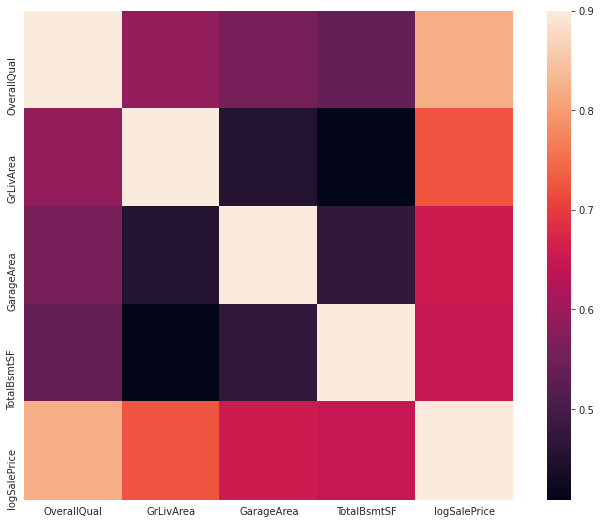

In [ ]:
corrmat = train[interesting_cols].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
interesting_data = all_data[interesting_cols][:]

In [ ]:
interesting_data['GarageArea'] = interesting_data['GarageArea'].fillna(interesting_data['GarageArea'].median())

In [ ]:
interesting_data['TotalBsmtSF'] = interesting_data['TotalBsmtSF'].fillna(interesting_data['TotalBsmtSF'].mean())

In [ ]:
train = interesting_data[:ntrain]
test = interesting_data[ntrain:]

Перейдем к моделированию

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=42))

In [ ]:
enet = make_pipeline(RobustScaler(), ElasticNet(random_state=42))

In [ ]:
svr = make_pipeline(RobustScaler(), StandardScaler(), SVR())

In [ ]:
GBoost = GradientBoostingRegressor(random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
model_xgb = xgb.XGBRegressor(random_state=42)

In [ ]:
model_lgb = lgb.LGBMRegressor(random_state=42)

In [ ]:
for i in [lasso, enet, svr, GBoost, rf, model_lgb, model_xgb]:
  print(cross_val_score(i, train, y_train, cv=5, scoring="neg_mean_squared_log_error"))

[-0.0008797  -0.00107168 -0.00098095 -0.00087855 -0.00089822]
[-0.0008797  -0.00107168 -0.00098095 -0.00087855 -0.00089822]
[-0.00016776 -0.00021386 -0.00016004 -0.00016522 -0.00016497]
[-0.00017331 -0.00018517 -0.00016528 -0.00015189 -0.00016353]
[-0.00019566 -0.00017959 -0.00017936 -0.0001607  -0.00017133]
[-0.00018284 -0.00019323 -0.00017643 -0.00017399 -0.00017314]
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squared

In [ ]:
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [ ]:
voting = VotingRegressor([("lasso", lasso), ("e", enet), ("s", svr), ("gb", GBoost), ("rf", rf),
                              ("lgb", model_lgb), ("xgb", model_xgb)])

In [ ]:
stacking = StackingRegressor([("lasso", lasso), ("e", enet), ("s", svr), ("gb", GBoost), ("rf", rf),
                              ("lgb", model_lgb), ("xgb", model_xgb)], final_estimator=rf)

In [ ]:
for i in [voting, stacking]:
  print(cross_val_score(i, train, y_train, cv=5, scoring="neg_mean_squared_log_error"))

[15:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-0.00021786 -0.00026732 -0.00024608 -0.00021911 -0.00020662]
[15:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:46] WARNING: /workspace/src/objective/regr

Отправляем

In [ ]:
estinators = [lasso, enet, svr, GBoost, rf, model_lgb, model_xgb, voting, stacking]

In [ ]:
stacking.fit(train, y_train)
y_pred = stacking.predict(test)
print(y_pred)
y_pred = np.expm1(y_pred)
print(y_pred)
ans = pd.DataFrame({"Id": test_ID,"SalePrice": y_pred})
ans.to_csv("submission_stack.csv", index=False)

[16:00:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11.756443 11.924029 11.908536 ... 11.866431 11.587721 12.377129]
[127571.875 150847.2   148528.06  ... 142404.

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_stack.csv -m "Message"

100% 21.2k/21.2k [00:00<00:00, 100kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
y_pred

array([11.86035037, 11.96446217, 11.94723417, ..., 11.95316908,
       11.68657584, 12.25458616])